<a href="https://colab.research.google.com/github/mlangsman/fastai-experiments/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Classifier Experiment

## 📁 Install dependencies

We need the Fastai library for model training and DuckDuckGo search to retrieve images for our dataset.


In [1]:
!pip install -Uqq fastai ddgs

## Download images

Create a function which can download images using the DuckDuckGo API for training.

In [2]:
from ddgs import DDGS
from fastcore.all import *

def search_images(keywords, max_images=20):
  results = DDGS().images(keywords, max_results=max_images) #run a search
  imageUrls = L(results).itemgot('image') #extract just image urls
  return imageUrls


Classifying UPF food is a little trickier than say cats/dogs. Here I create a list of search terms for specific foods and so we can then grab images for each


In [3]:
# Ultra-processed food terms (UPF)
upf_terms = [
    "Big Mac burger",
    "Doritos crisps",
    "KitKat bar",
    "Oreo cookies",
    "Pringles tube",
    "Pot Noodle",
    "Twix bar",
    "Haribo sweets",
    "Coca-Cola can",
    "Fanta bottle",
    "Red Bull can",
    "Pop-Tarts",
    "Ben & Jerry's ice cream tub",
    "Chicken nuggets",
    "Pepperami",
    "Frozen pizza",
    "Pot noodle",
    "Mars bar",
    "Snickers bar",
    "Chocolate bar"
    "Walkers crisps",
    "Crisps"
]

# Fresh / minimally-processed foods
fresh_terms = [
    "Apple fruit",
    "Banana fruit",
    "Broccoli",
    "Carrot",
    "Tomato",
    "Cucumber",
    "Lettuce",
    "Blueberries",
    "Strawberries",
    "Eggs",
    "Whole chicken raw",
    "Salmon fillet",
    "Beef steak",
    "Brown rice bowl",
    "Oats porridge",
    "Almonds nuts",
    "Avocado",
    "Red bell pepper",
    "Courgette",
    "Mushrooms"
]

Let's create a function to downloading some images for each term. FastAi's download_url() seems to stall on some urls so here I'm doing an http request instead to get the images.

In [16]:
from fastdownload import download_url
from fastai.vision.all import *
from io import BytesIO
import random

thumbs = []

def download_image_sets(search_term_list, dest_path, max_images):
  for item in search_term_list:
    urls = search_images(item, max_images=max_images)
    for i, url in enumerate(urls):
      file_name = f"{item.replace(' ', '_')}_{i}.jpg"
      dest = dest_path/file_name
      try:
        r = requests.get(url, timeout=4, headers={"User-Agent": "Mozilla/5.0"})
        r.raise_for_status()
        if "image" not in r.headers.get("Content-Type", ""): # skip non-image content
          continue

        # Create image from raw bytes and also write to disk
        img = PILImage.create(BytesIO(r.content))
        with open(dest, "wb") as f:
                  f.write(r.content)
        thumbs.append(img.to_thumb(64,64))
      except Exception as e:
        continue

  #show_images(thumbs, nrows=len(upf_terms))

Test this out with a small no. images to check if the results make sense



In [ ]:
download_image_sets(upf_terms,3)

This looks good so lets download 10 images for each search term and save them in folders for the two categories

In [ ]:
from time import sleep

searches = {
    "upf": upf_terms,
    "fresh": fresh_terms
}

path = Path('upf_or_not')

for label, terms in searches.items():
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    download_image_sets(terms,dest,10)
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/label, max_size=400, dest=path/label)

## 🏋 Train the model

Remove any images which didnt download properly and may affect training


In [19]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train the model first we create a DataBlock which defines:

* We're inputting image data => mapping to categories
* Get the input items using get_image_files() which finds at jpg/gif under the given path
* We randomly split the images 80/20 for training/validation. The seed lets us recreate this pseudo-random split again.
* Classifier label using the folder names
* All the images need to be the same size so we'll tranform each item to 192x192

The dataloader then populates this using our path


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)


Lets see if the input data is looking good:

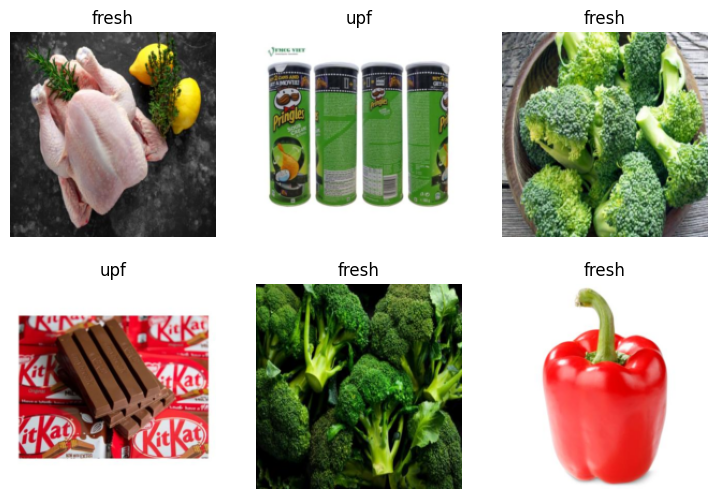

In [21]:
dls.show_batch(max_n=6)

Time to run the training using the Resnet18 model. This is the smallest 'residual network' from microsoft with 18 layers. This means it's fast to train.

The model is pre-trained with on the ImageNet dataset (1.2M images, 1000 classes). In this fine-tuning there are two blocks:

1. The last layer (head) is removed and replaced with a new one for our upf use-case. The rest of the model is frozen and the head is trained in 1 epoch.
2. Then the rest of the model is gradually trained with a lower learning rate over 3 epochs.

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.092475,0.161084,0.077922,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.324838,0.080049,0.025974,00:59
1,0.196779,0.044981,0.025974,01:00
2,0.150942,0.038551,0.025974,01:03


## Test the model

In [31]:
url = input("Paste an image URL: ")

!wget -O test.jpg "$url"

is_upf, _, probs = learn.predict(PILImage.create('test.jpg'))

print(f"This is a: {is_upf}.")
for cls, p in zip(learn.dls.vocab, probs):
    print(f"Probability it's {cls}: {p:.4f}")

Paste an image URL: https://img.kwcdn.com/product/fancy/164a60a0-d5e5-42f1-9348-02233802c558.jpg?imageView2/2/w/264/q/70/format/webp
--2025-09-29 19:26:16--  https://img.kwcdn.com/product/fancy/164a60a0-d5e5-42f1-9348-02233802c558.jpg?imageView2/2/w/264/q/70/format/webp
Resolving img.kwcdn.com (img.kwcdn.com)... 109.61.91.197, 109.61.91.194, 109.61.91.231, ...
Connecting to img.kwcdn.com (img.kwcdn.com)|109.61.91.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3082 (3.0K) [image/webp]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]   3.01K  --.-KB/s    in 0s      

2025-09-29 19:26:16 (1.71 GB/s) - ‘test.jpg’ saved [3082/3082]



This is a: fresh.
Probability it's fresh: 0.9401
Probability it's upf: 0.0599


In [22]:
is_upf,_,probs = learn.predict(PILImage.create('test.jpg'))
